# decentralized
Primary development and execution script for evaluation of game theoretic control algorithms.

References:
1. [Fridovich-Keil - ilqgames](https://github.com/HJReachability/ilqgames/blob/master/python/dynamical_system.py)
1. [Jackson, Howell - iLQR Tutorial](http://roboticexplorationlab.org/papers/iLQR_Tutorial.pdf)
1. [Jackson - AL iLQR Tutorial](https://bjack205.github.io/papers/AL_iLQR_Tutorial.pdf)
1. [Sears-Collins - Linear Quadratic Regulator Python Example](https://automaticaddison.com/linear-quadratic-regulator-lqr-with-python-code-example/)

In [1]:
import sys
sys.path.append('/mnt/c/Users/ZachJW/Documents/Grad/Research/decentralized/decentralized/')

import numpy as np
import matplotlib.pyplot as plt

from control import iLQR, LQR
from models import DoubleInt1dDynamics, DoubleInt2dDynamics
from models import CarDynamics, UnicycleDynamics, BicycleDynamics
from dynamics import MultiDynamicalModel
from cost import ObstacleCost, ReferenceCost, CouplingCost, AgentCost
from util import Point

In [3]:
# %matplotlib ipympl
np.set_printoptions(precision=3, suppress=True)

In [4]:
plt.figure()
plt.show()

<Figure size 432x288 with 0 Axes>

### Combining Dynamical Models

In [5]:
dt = 1.0
uni = UnicycleDynamics(dt)
car = CarDynamics(dt)
bike = BicycleDynamics(dt)
md = MultiDynamicalModel([uni, car, bike])
md.x_dims

[4, 3, 5]

In [6]:
x = np.random.randint(10, size=md.n_x)
u = np.random.randint(10, size=md.n_u)
x_next = md(x, u)
A, B = md.linearize(x, u)

In [7]:
x = np.array([0, 0, 6, 5, 
              0, 1, 5, 
            -0.5, 2, 2, 0, 4])

In [8]:
pos_inds = [(0, 1), (4, 5), (7, 8)]
max_distance = 2.0
coup_cost = CouplingCost(pos_inds, max_distance)
L = coup_cost(x)
L_x, L_u, L_xx, L_uu, L_ux = coup_cost.quadraticize(x, u)

TypeError: quadraticize() takes 2 positional arguments but 3 were given

In [9]:
from cost import quadraticize_distance

In [10]:
pa = Point(x[pos_inds[0][0]], x[pos_inds[0][1]])
pb = Point(x[pos_inds[1][0]], x[pos_inds[1][1]])
pa, pb

((0.0, 0.0), (0.0, 1.0))

In [11]:
L_xi, L_xxi = quadraticize_distance(pa, pb, max_distance)
L_xi, L_xxi

(array([-0.,  2.]),
 array([[-2., -0.],
        [-0.,  2.]]))

### iLQR

In [9]:
dt = 0.1
N = 60
n_lqr_iter = 50
tol = 1e-3

# dynamics = DoubleInt1dDynamics(dt)
# x0 = np.array([2, 0])
# xf = np.array([0, 1])
# Q = np.eye(2)
# R = np.eye(1)

# dynamics = DoubleInt2dDynamics(dt)
# x0 = np.array([10, 10, 0, 0])
# xf = np.array([0, 0, 0, 0])
# Q = np.diag([1, 1, 0, 0])
# R = np.eye(2)

dynamics = CarDynamics(dt)
x0 = np.array([11, 11, np.pi/2])
xf = np.array([0, 0, 0])
Q = np.diag([1, 1, 0])
R = np.eye(2)

# dynamics = UnicycleDynamics(dt)
# x0 = np.array([0, 0, 0, 0])
# xf = np.array([10, 10, 0, np.pi/4])
# Q = np.diag([1, 1, 0, 0])
# R = np.eye(2)

# dynamics = BicycleDynamics(dt)
# x0 = np.array([10, 10, np.pi/2, 0, 0])
# xf = np.array([0, 0, 0, 0, 0])
# Q = np.diag([1, 1, 0, 0, 0])
# R = np.eye(2)

Qf = np.eye(Q.shape[0]) * 1e3
reference = ReferenceCost(xf, Q, R, Qf)
obstacles = [ObstacleCost((0, 1), Point(3, 3), 2),
             ObstacleCost((0, 1), Point(9, 7), 2),
             ObstacleCost((0, 1), Point(3, 10), 3)]

REF_WEIGHT = 1.0
OBS_WEIGHT = 1e6
weights = [OBS_WEIGHT] * len(obstacles) + [REF_WEIGHT]
agent_cost = AgentCost(obstacles + [reference], weights)

In [10]:
ilqr = iLQR(dynamics, agent_cost, N=N)
X, U, Jf = ilqr.run(x0, n_lqr_iter, tol)

0/50	J: 258987
1/50	J: 102337	μ: 0.5	Δ: 0.5
2/50	J: 35982.7	μ: 0.125	Δ: 0.25
3/50	J: 23275	μ: 0.015625	Δ: 0.125
4/50	J: 19754.6	μ: 0.000976562	Δ: 0.0625
5/50	J: 18705.3	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 18417.5	μ: 0	Δ: 0.015625
7/50	J: 18220.2	μ: 0	Δ: 0.0078125
8/50	J: 8334.76	μ: 0	Δ: 0.00390625
9/50	J: 3492.19	μ: 0	Δ: 0.00195312
 

         1043041 function calls (986362 primitive calls) in 2.904 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
129558/72879    0.471    0.000    1.325    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    15780    0.368    0.000    0.906    0.000 models.py:126(f)
     3600    0.202    0.000    1.656    0.000 _numdiff.py:257(approx_derivative)
     3600    0.146    0.000    0.893    0.000 _numdiff.py:547(_dense_difference)
       10    0.121    0.012    2.277    0.228 control.py:184(backward_pass)
    15780    0.114    0.000    0.400    0.000 shape_base.py:357(stack)
       52    0.075    0.001    0.585    0.011 control.py:163(forward_pass)
     9699    0.074    0.000    0.168    0.000 linalg.py:2363(norm)
     3233    0.067    0.000    0.067    0.000 cost.py:65(__call__)
      610    0.062    0.000    0.126    0.000 cost.py:222(quadraticize)
     9699    0.061    0.000    0.264    0.000 cos

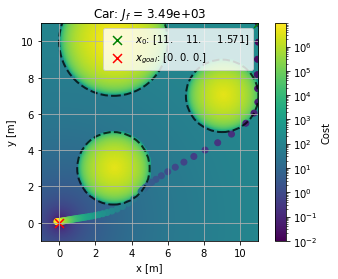

In [11]:
ilqr.plot(X, Jf, False, 
          surface_plot=True, 
          log_colors=True,
          axis=(-1,11,-1,11)
         )

### LQR

In [4]:
N = 60
dt = 0.1

dynamics = DoubleInt1dDynamics(dt)
x0 = np.array([10, 0])
xf = np.array([0, 0])
Q = np.diag([1, 1])
R = np.eye(1)

# dynamics = DoubleInt2dDynamics(dt)
# x0 = np.array([1, 1, 0, 0])
# xf = np.array([0, 0, 0, 0])
# Q = np.eye(4)
# R = np.eye(2)

# dynamics = CarDynamics(dt)
# x0 = np.array([5.0, 5.0, np.pi/2])
# xf = np.array([0, 0, 0])
# Q = np.diag([1, 1, 0])
# R = np.eye(2) * 0.01

# dynamics = UnicycleDynamics(dt)
# x0 = np.array([-1, -1, 0, np.pi/3])
# xf = np.array([0, 0, 0, 0])
# Q = np.diag([1, 1, 0, 0])
# R = np.eye(2)

Qf = np.eye(Q.shape[0]) * 1e3
quad_cost = ReferenceCost(xf, Q, R, Qf)
lqr = LQR(dynamics, quad_cost, N=N)
X, U, J = lqr.run(x0)
lqr.plot(X, J)

AttributeError: 'AgentCost' object has no attribute 'Q'